In [346]:
import numpy as np
import pandas as pd
import sys
import datetime as dt
import matplotlib as plt
from sklearn.metrics import recall_score
# !{sys.executable} -m pip install gspread

# Data Cleaning

In [347]:
dfs = pd.read_excel("Copy of timesheet.xlsx")
i = 0
for col in dfs.columns:
	if(i%4 == 0):
		dfs.rename(columns={col: "start" + "." + str(int(i/4))}, inplace=True)
	elif(i%4 == 1):
		dfs.rename(columns={col: "end" + "." + str(int((i-1)/4))}, inplace=True)
	elif(i%4 == 2):
		dfs.rename(columns={col: "act" + "." + str(int((i-2)/4))}, inplace=True)
	elif(i%4 == 3):
		dfs.loc[0, col] = str(col[0:3])
		dfs.rename(columns={col: "dur" + "." + str(int((i-3)/4))}, inplace=True)
	i+=1

In [348]:
dur_cols = [c for c in dfs.columns if "dur" in c]

for col in dur_cols:
	for i in range(dfs[col].size):
		curr = dfs[col][i]
		curr_type = (type(curr))
		if curr_type is float:
			pass
		elif curr_type is str:
			pass
		elif curr_type is dt.datetime or curr_type is dt.time:
			dur_min = curr.hour * 60 + curr.minute
			dfs.loc[i, col] = dur_min
		else:
			print(curr)
			print(curr_type) 

	

start_cols = [s for s in dfs.columns if ("start" in s or "end" in s)]
for col in start_cols:
	for i in range(dfs[col].size):
		if ("start" in col) and (i == 0):
			dfs.loc[i, col] = dfs[col][i].date()
			continue
		curr = dfs[col][i]
		curr_type = type(curr)
		if curr_type is float or curr is pd.NaT or curr_type is bool:
			pass
		elif curr_type is dt.datetime:
			dfs.loc[i, col] = curr.replace(second=0, microsecond=0).time()
		elif curr_type is dt.time:
			dfs.loc[i, col] = curr.replace(second=0, microsecond=0)
		elif curr_type is pd.Timestamp:
			curr_time = dt.time(curr.hour, curr.minute, 0)
			dfs.loc[i, col] = curr_time
		else:
			print(curr)
			print(curr_type) 

C:\Users\wasif\AppData\Local\Temp\ipykernel_10960\1127516766.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2025-10-10' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  dfs.loc[i, col] = dfs[col][i].date()
C:\Users\wasif\AppData\Local\Temp\ipykernel_10960\1127516766.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2025-12-03' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  dfs.loc[i, col] = dfs[col][i].date()
C:\Users\wasif\AppData\Local\Temp\ipykernel_10960\1127516766.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2025-12-04' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  dfs.l

In [349]:
dates_raw = [
    "23/09/2025",
    "07/10/2025",
    "08/10/2025",
    "20/10/2025",
    "22/10/2025",
    "25/10/2025",
    "28/10/2025",
    "02/11/2025",
    "10/11/2025",
    "16/11/2025",
    "20/11/2025",
    "26/11/2025",
    "27/11/2025",
    "02/12/2025",
    "05/12/2025"
]

vivid_dream_dates = [dt.datetime.strptime(d, "%d/%m/%Y").date() for d in dates_raw]

dates_r = [
	"06/09/2025",
	"09/09/2025",
	"10/09/2025",
	"15/09/2025",
	"15/09/2025",
	"15/09/2025",
	"20/09/2025",
	"20/09/2025",
	"25/09/2025",
	"29/09/2025",
	"07/10/2025",
	"14/10/2025",
	"14/10/2025",
	"14/10/2025",
	"15/11/2025",
	"27/11/2025",
	"06/12/2025",
]

vague_dream_dates =  [dt.datetime.strptime(d, "%d/%m/%Y").date() for d in dates_r]

In [350]:
num_days = int(dfs.shape[1] / 4)
results = []
for i in range(num_days):
	# day_length = (dfs["dur." + str(i)][1::].sum())

	curr_date = dfs["start." + str(i)][0]
	total_sleep = dfs[dfs["act." + str(i)] == "sleep"]["dur." + str(i)].sum()
	total_cimic = dfs[dfs["act." + str(i)] == "cimic"]["dur." + str(i)].sum()
	total_shower = dfs[dfs["act." + str(i)] == "shower"]["dur." + str(i)].sum()

	#handle talk
	total_talk = dfs[dfs["act." + str(i)] == "talk"]["dur." + str(i)].sum()

	#handle day logic
	curr_day = dfs["dur." + str(i)][0]
	day_to_int = {
		"MON": 0,
		"TUE": 1,
		"WED": 2,
		"THU": 3,
		"FRI": 4,
		"SAT": 5,
		"SUN": 6,
	}
	curr_day = int(day_to_int[curr_day])

	#handle workout logic
	total_bjj = dfs[dfs["act." + str(i)] == "bjj"]["dur." + str(i)].sum()
	total_swim = dfs[dfs["act." + str(i)] == "crce swim"]["dur." + str(i)].sum()
	total_workout = total_bjj + total_swim
	
	#handle coursework logic
	mask_course = (
		dfs["act." + str(i)]
		.astype(str)
		.str.match(r"^\d{3}\b", na=False)
	)
	total_course = dfs.loc[mask_course, "dur." + str(i)].sum()


	#handle dream logic
	curr_dream = "none"
	if(curr_date in vague_dream_dates):
		curr_dream = "dream"
	if(curr_date in vivid_dream_dates):
		curr_dream = "dream"

	#compile data in dictionary
	out = {
		"date": curr_date,
		"day": curr_day,
		"sleep": total_sleep,
		"cimic": total_cimic,
		"hw": total_course,
		"talk": total_talk,
		"workout": bool(total_workout > 0),
		"shower": bool(total_shower > 0),
		"dream": curr_dream
		
	}

	results.append(out)
summary_df = pd.DataFrame(results)

	

In [351]:
summary_arry = summary_df.to_numpy()
np.random.seed(441) 
np.random.shuffle(summary_arry)
feature_names = summary_df.columns.to_numpy()[1:-1]


x = summary_arry[:, 1:-1]
y = summary_arry[:, -1]

#validation split
# n_train = 40
# n_val = n_train + 15
# x_train = x[0:n_train]
# y_train = y[0:n_train]
# x_val = x[n_train:n_val]
# y_val = y[n_train:n_val]
# x_test = x[n_val::]
# y_test = y[n_val::]


# Baseline Models
No adjustments to a validation set is used

These are just models to give a baseline accuracy

In [372]:
def recall_helper(y_true, y_hat):
    TP = 0
    FN = 0
    
    for i in range(len(y_true)):
        if y_true[i] == "dream" and y_hat[i] == "dream":  # True Positive
            TP += 1
        elif y_true[i] == "dream" and y_hat[i] == "none":  # False Negative
            FN += 1

    # Calculate recall
    if TP + FN == 0:  # Prevent division by zero
        return 0.0
    return TP / (TP + FN)

def calculate_recall(curr_model, x, y_true):
    y_hat = curr_model.predict(x)
    return recall_helper(y_true, y_hat)


In [373]:
#no validation in this split
n_train = 45
x_train = x[0:n_train]
y_train = y[0:n_train]
x_test = x[n_train::]
y_test = y[n_train::]

none_predict = np.zeros_like(y_test)
baseline_recall = recall_helper(y_test, none_predict)
baseline_accuracy = y[np.where(y == "none")].shape[0] / y.shape[0]
print("if we always guess none")
print(f"baseline recall on test: {baseline_recall}")
print(f"baseline accuracy on test: {baseline_accuracy}")



if we always guess none
baseline recall on test: 0.0
baseline accuracy on test: 0.7464788732394366


In [374]:
def print_model_evaluation(model, xtrain=x_train, ytrain=y_train, xtest=x_test, ytest=y_test):
	train_accuracy = model.score(xtrain, ytrain)
	test_accuracy = model.score(xtest, ytest)

	train_recall = calculate_recall(model, xtrain, ytrain)
	test_recall = calculate_recall(model, xtest, ytest)

	print(f"train accuracy: {train_accuracy}, train recall = {train_recall}")
	print(f"test accuracy: {test_accuracy} , test recall = {test_recall}")

train accuracy: 0.8222222222222222, train recall = 0.2727272727272727
test accuracy: 0.6923076923076923 , test recall = 0.0


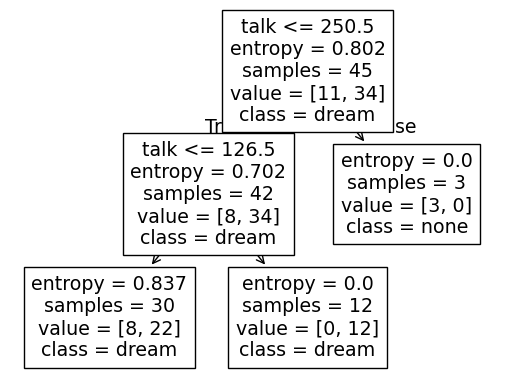

In [375]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib as plt
basic_tree = DecisionTreeClassifier(criterion='entropy', max_depth=2)

basic_tree.fit(x_train,y_train)
plot_tree(
    basic_tree,
    feature_names= feature_names,
    class_names=["none", "dream"]
)
train_recall = calculate_recall(basic_tree, x_train, y_train)
test_recall = calculate_recall(basic_tree, x_test, y_test)
print_model_evaluation(basic_tree)

In [377]:
from sklearn.linear_model import LogisticRegression
basic_regression = LogisticRegression()
basic_regression.fit(x_train, y_train)
train_recall = calculate_recall(basic_regression, x_train, y_train)
test_recall = calculate_recall(basic_regression, x_test, y_test)
print_model_evaluation(basic_regression)

train accuracy: 0.8, train recall = 0.18181818181818182
test accuracy: 0.5769230769230769 , test recall = 0.0


c:\Users\wasif\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Random Forest

In [387]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
accuracy_3 = []
accuracy_5 = []
accuracy_10 = []
n_est_arr = []

i = 3
while i < 250:
	rand_forest = RandomForestClassifier(n_estimators=i, criterion='entropy')
	rand_forest.fit(x_train, y_train)
	scores_3 = cross_val_score(rand_forest, x_train, y_train, cv=3, scoring=calculate_recall)
	scores_5 = cross_val_score(rand_forest, x_train, y_train, cv=5, scoring=calculate_recall)
	scores_10 = cross_val_score(rand_forest, x_train, y_train, cv=10, scoring=calculate_recall)

	n_est_arr.append(i)
	accuracy_3.append(scores_3.mean())
	accuracy_5.append(scores_5.mean())
	accuracy_10.append(scores_10.mean())

	if i < 50:
		i = i + 1
	elif i < 100:
		i = i + 5
	elif i < 300:
		i = i + 20





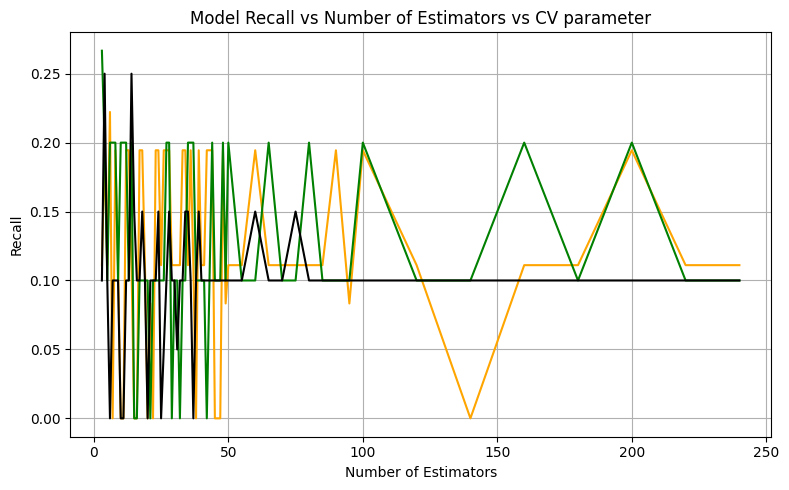

In [388]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(n_est_arr, accuracy_3, color="orange")
plt.plot(n_est_arr, accuracy_5, color="green")
plt.plot(n_est_arr, accuracy_10, color="black")
plt.xlabel("Number of Estimators")
plt.ylabel("Recall")
plt.title("Model Recall vs Number of Estimators vs CV parameter")
plt.grid(True)
plt.tight_layout()
plt.show()


After 100, the recall seems to stabalize instead of jumping too much

Note that this graph shows us that our cv paramater seems to not change anything too much

In [389]:
final_forest = RandomForestClassifier(n_estimators=200)
final_forest.fit(x_train, y_train)
final_scores = cross_val_score(final_forest, x_train, y_train, cv=10, scoring=calculate_recall)
print_model_evaluation(final_forest)

train accuracy: 1.0, train recall = 1.0
test accuracy: 0.6538461538461539 , test recall = 0.0


# Logistic Regression

In [362]:
from sklearn.preprocessing import StandardScaler

x_std = x.copy()

scaler = StandardScaler()
x_std[:, 1:4] = scaler.fit_transform(x_std[:, 1:4])

In [363]:
#no validation in this split
n_train = 45
x_train_std = x_std[0:n_train]
y_train_std = y[0:n_train]
x_test_std = x_std[n_train::]
y_test_std = y[n_train::]

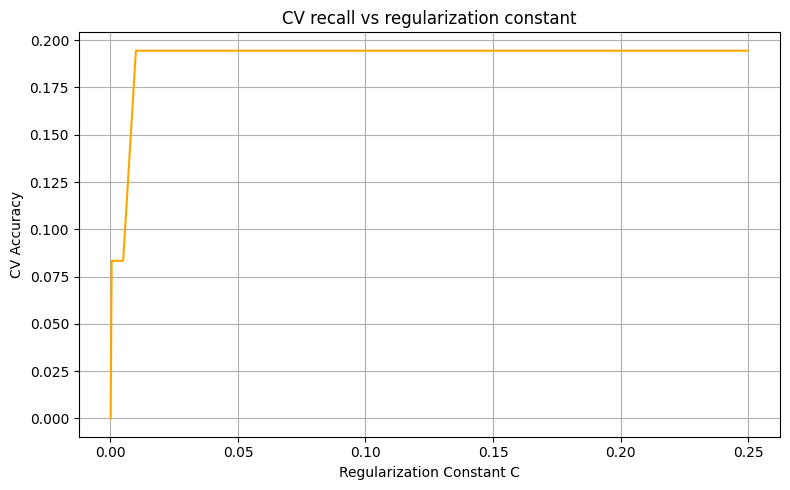

train accuracy: 0.8, train recall = 0.18181818181818182
test accuracy: 0.6923076923076923 , test recall = 0.0


In [390]:
from sklearn.linear_model import LogisticRegression

C = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.015, 0.02, 0.05, 0.10, 0.25]
val_accuracy = []
final_model = None
for c in C:
	log_regression = LogisticRegression(penalty="l2", max_iter=10000, C=c)
	log_regression.fit(x_train_std, y_train_std)
	if c == 0.1:
		final_model = log_regression
	std_scores = cross_val_score(log_regression, x_train_std, y_train_std, cv=3, scoring=calculate_recall)
	val_accuracy.append(std_scores.mean())


plt.figure(figsize=(8, 5))
plt.plot(C, val_accuracy, color="orange")
plt.xlabel("Regularization Constant C")
plt.ylabel("CV Accuracy")
plt.title("CV recall vs regularization constant")
plt.grid(True)
plt.tight_layout()
plt.show()
print_model_evaluation(final_model, x_train_std, y_train_std, x_test_std, y_test_std)